In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import gc
from read_train import *
from astropy.stats import LombScargle
from scipy.signal import find_peaks_cwt, find_peaks

info = init_reading()

In [2]:
train = read_object_info(info, 2)
#rename columns - quicker to type!
train.columns = ['signal', 'ttf']
print(train.describe())


             signal           ttf
count  5.459148e+07  5.459148e+07
mean   4.797263e+00  7.090703e+00
std    9.466310e+00  4.093675e+00
min   -3.112000e+03  7.954851e-04
25%    2.000000e+00  3.545174e+00
50%    5.000000e+00  7.090698e+00
75%    7.000000e+00  1.063540e+01
max    4.610000e+03  1.418060e+01


In [ ]:
train.plot(kind='scatter',x='ttf',y='signal', s=1)
plt.xlim(1.5, -0.05)
plt.title('Acoustic signal/ttf')
plt.show()

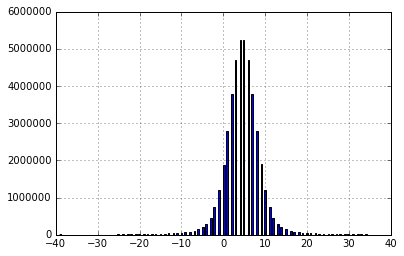

In [3]:
train.loc[(train.signal < 40) & (train.signal > -40), ].signal.hist(bins=200)

In [3]:

t = train.ttf.values
y = train.signal.values

#astropy implementation works directly on frequency, not angular frequency
#autopower() calculates a frequency grid automatically based on mean time separation
frequency, power = LombScargle(t[0:10000], y[0:10000]).autopower(nyquist_factor=2)

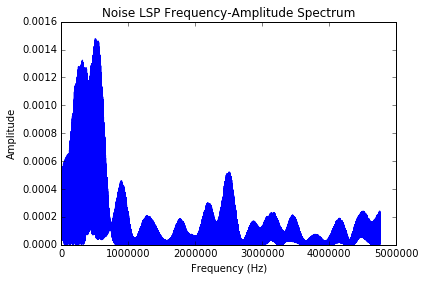

In [4]:
plt.plot(frequency, power) 
plt.title('Noise LSP Frequency-Amplitude Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.show()


In [5]:
def cluster_peaks(x, peaks, diffs, threshold):
    i = 0
    best_peaks = []
    diffs = np.append(diffs, 0)
    
    while(i < len(diffs)):
        cluster = []
        flag = 0
        t = threshold
        while(t > 0):
            cluster.append(peaks[i])
            t -= diffs[i]
            i += 1
            if(i >= len(peaks)):
                break;

        mx = x[cluster[0]]
        ind = cluster[0]
        for c in range(1,len(cluster)):
            if (x[cluster[c]] > mx):
                mx = x[cluster[c]]
                ind = cluster[c]
        best_peaks.append(ind)
        
       
    return best_peaks

def find_best(Pxx_den, peaks, no_of_best):
    best = []
    for i in peaks:
        best.append([Pxx_den[i], i])
    best = sorted(best, key=lambda tup: tup[0])
    peaks = []
    for i in range(no_of_best):
        peaks.append(best[-(i+1)][1])
    return peaks


def arr_dist(arr, sep, n=5):
    output = []
    for i,x in enumerate(arr):
        keep=True
        for y in output:
            if abs(y-x)<sep:
                keep=False
                break
        if(keep):
            output.append(i)
            if len(output)==n:
                return(np.asarray(output))

[ 2256  5316  9373 13453 18662 22956 26319 30125 33393 36401 39842 43693
 46968 49976]


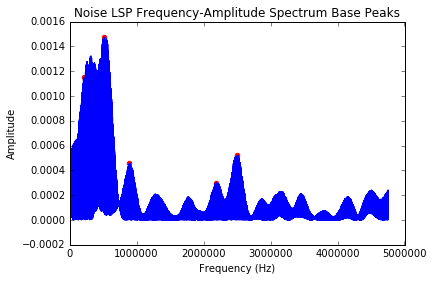

[ 2425  5511  9314 12942 16150 19156 22197 25577 28867 31874 35750 39375
 42428 45841 48979]


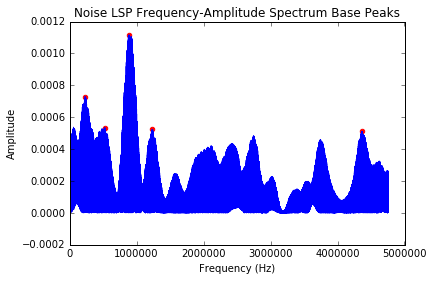

[  851  6705 10099 15274 19255 23233 27945 30951 36275 41956 45031 49908]


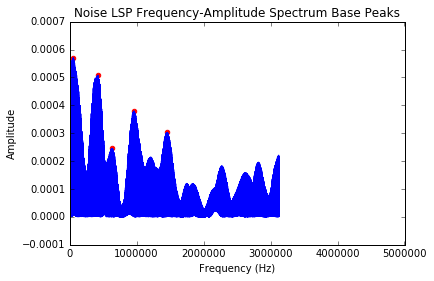

[  867  5731 10157 13488 18091 21535 24627 27774 31541 34847 39207 44522
 48769]


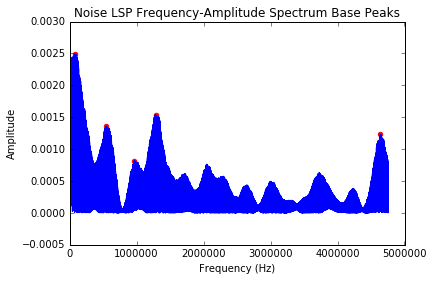

[ 1076  4317  9804 14775 17800 20907 24563 27594 31270 34316 37332 41897
 47858]


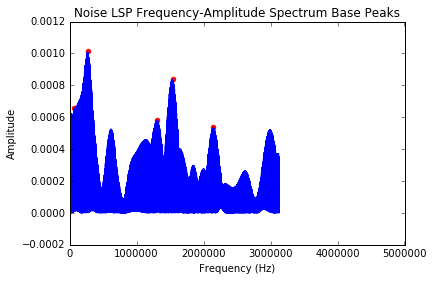

In [15]:
for i in range(5):
    frequency, power = LombScargle(t[i*10000:10000*(i+1)], y[i*10000:10000*(i+1)]).autopower(nyquist_factor=2)
    dist = 3000
    peaks = []
    while(True):
        peaks, _ = find_peaks(power, distance = 3000)
        if(len(peaks) >= 5):
            break;
        else:
            distance = distance/ 2
    #peaks  = cluster_peaks(frequency, peaks, np.diff(peaks),3000)
    peaks = find_best(power, peaks, 5)
    #print(peaks)
    plt.plot(frequency, power)
    plt.scatter(frequency[peaks], power[peaks], color = "red")
    plt.title('Noise LSP Frequency-Amplitude Spectrum Base Peaks')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')
    plt.xlim(0, 5e6)
    plt.show()


In [6]:
def LSP_freq(df, signal_col, time_col, nrows, min_freq, max_freq, freq_sep, threshold):
    print('Lomb-Scargle Periodogram analysis commencing.')
    print('Minimum detection frequency: {}Hz'.format(MIN_FREQ))
    print('Manual maximum frequency cutoff: {}Hz'.format(MAX_FREQ))
    print('Number of segments: ', round(len(df)/ROWS_PER_SEGMENT))
    #initialise empty arrays for frequency outputs to be concatenated to DataFrame 
    freq_1 = np.zeros(len(df))
    freq_2 = np.zeros(len(df))
    freq_3 = np.zeros(len(df))
    freq_4 = np.zeros(len(df))
    freq_5 = np.zeros(len(df))
    freq_0 = np.zeros(len(df))
    amps_0 = np.zeros(len(df))
    segment_num = np.zeros(len(df))
    #loop through input DataFrame in chunks of length=nrows
    init_id = 0
    segment_id =1
    while init_id < len(df):
        if segment_id==1:
            print('Processing segment {:d}...'.format(segment_id))
        if segment_id%25==0:
            print('Processing segment {:d}...'.format(segment_id))
        end_id = min(init_id + nrows, len(df))
        ids = range(init_id, end_id)
        df_chunk = df.iloc[ids]
        #np arrays of amplitude and time columns
        signal = df_chunk[signal_col].values
        ttf = df_chunk[time_col].values
        #clear memory
        del df_chunk
        gc.collect()
        #calulate Lomb-Scargle periodograms for spectral analysis
        freq, power = LombScargle(ttf, signal).autopower(nyquist_factor=2)
        freq_df = pd.DataFrame({'freq': freq.round(),
                               'amp': power})
        
        #obtain frequencies sorted by highest amplitude as np.array

        top_freqs = freq_df.loc[(freq_df.freq > min_freq) & (freq_df.freq < max_freq)].values
        #obtain top 5 values that do not lie within 3kHz of eachother
        peaks, _ = find_peaks(top_freqs[:,0], distance = 3000)

        #peaks  = cluster_peaks(top_freqs[:,1], peaks, np.diff(peaks),3000)
        peaks = find_best(top_freqs[:,0], peaks, 5)
        freqs = np.sort(top_freqs[peaks,1])
    
        #freq_df = freq_df.loc[freq_df['amp'] >= threshold] 
      
        periodic_freq= freq_df.loc[(freq_df.freq > min_freq) & (freq_df.freq < max_freq)].sort_values('amp', ascending=False).freq.values
        periodic_amp = freq_df.loc[(freq_df.freq > min_freq) & (freq_df.freq < max_freq)].sort_values('amp', ascending=False).amp.values

        #update main frequency component arrays
        freq_1[ids] = freqs[4]
        freq_2[ids] = freqs[3]
        freq_3[ids] = freqs[2]
        freq_4[ids] = freqs[1]
        freq_5[ids] = freqs[0]
        try:
            freq_0[ids] = periodic_freq[0]
            amps_0[ids] = periodic_amp[0]
        except:
            freq_0[ids] = 0
        del freq_df, top_freqs, freq, power, peaks
        gc.collect()
        segment_num[ids] = segment_id
        #del top_freqs
        init_id += nrows
        segment_id += 1
    print('...Done. Adding main component frequencies as DataFrame columns...')
    df['Freq_1'] = freq_1
    df['Freq_2'] = freq_2
    df['Freq_3'] = freq_3
    df['Freq_4'] = freq_4
    df['Freq_5'] = freq_5
    df['Freq_periodic'] = freq_0
    df['Amps_periodic'] = amps_0
    df['Segment'] = segment_num
    df['Freq_MinMax'] = df['Freq_1'] - df['Freq_5']
    print('...Done.')
    

In [ ]:
full_train = pd.DataFrame()

for i in range(2):
    train = read_object_info(info, i)
    ROWS_PER_SEGMENT = 10000
    TIME_PER_SEGMENT = train.iloc[0, 1] - train.iloc[ROWS_PER_SEGMENT, 1]
    print(TIME_PER_SEGMENT)
    MIN_FREQ = round(1/TIME_PER_SEGMENT)
    MAX_FREQ = 1e8
    FREQ_SEP = 0.2e6
    LSP_freq(train, signal_col = 'acoustic_data', time_col = 'time_to_failure', nrows = ROWS_PER_SEGMENT, 
             min_freq = MIN_FREQ, max_freq = MAX_FREQ, freq_sep = FREQ_SEP, threshold = 0.1)
    full_train = full_train.append(train)

0.0021019888000000098
Lomb-Scargle Periodogram analysis commencing.
Minimum detection frequency: 476.0Hz
Manual maximum frequency cutoff: 100000000.0Hz
Number of segments:  566
Processing segment 1...
Processing segment 25...
Processing segment 50...
Processing segment 75...
Processing segment 100...
Processing segment 125...
Processing segment 150...
Processing segment 175...
Processing segment 200...
Processing segment 225...
Processing segment 250...
Processing segment 275...
Processing segment 300...
Processing segment 325...
Processing segment 350...


In [11]:
full_train

,acoustic_data,time_to_failure,Freq_1,Freq_2,Freq_3,Freq_4,Freq_5,Freq_periodic,Amps_periodic,Segment,Freq_MinMax
0,12,1.469100,4187988.0,3157916.0,1079597.0,467034.0,101856.0,101856.0,0.000088,1.0,4086132.0
1,6,1.469100,4187988.0,3157916.0,1079597.0,467034.0,101856.0,101856.0,0.000088,1.0,4086132.0
2,8,1.469100,4187988.0,3157916.0,1079597.0,467034.0,101856.0,101856.0,0.000088,1.0,4086132.0
3,5,1.469100,4187988.0,3157916.0,1079597.0,467034.0,101856.0,101856.0,0.000088,1.0,4086132.0
4,8,1.469100,4187988.0,3157916.0,1079597.0,467034.0,101856.0,101856.0,0.000088,1.0,4086132.0
5,8,1.469100,4187988.0,3157916.0,1079597.0,467034.0,101856.0,101856.0,0.000088,1.0,4086132.0
6,9,1.469100,4187988.0,3157916.0,1079597.0,467034.0,101856.0,101856.0,0.000088,1.0,4086132.0
7,7,1.469100,4187988.0,3157916.0,1079597.0,467034.0,101856.0,101856.0,0.000088,1.0,4086132.0
8,-5,1.469100,4187988.0,3157916.0,1079597.0,467034.0,101856.0,101856.0,0.000088,1.0,4086132.0
9,3,1.469100,4187988.0,3157916.0,1079597.0,467034.0,101856.0,101856.0,0.000088,1.0,4086132.0


In [8]:
cols = ['Freq_1', 'Freq_2','Freq_3','Freq_4','Freq_5']
for x in cols:
    train[x + '_RM'] = train[x].rolling(window=100000,center=False).mean()
cols_rm = []
for x in range(0, 5):
    cols_rm.append(cols[x] + '_RM')

ax = plt.gca()
train.plot(kind='line',x='time_to_failure',y=cols_rm ,ax=ax, figsize=(12, 6))
plt.xlim(1.5, -0.05)
plt.title('5 Main Noise Component Frequencies (LSP, min separation 200kHz)')
plt.xlabel('TTF(s)')
plt.ylabel('Frequency (Hz)')
plt.show()

KeyError: 'Freq_1'

In [7]:
# Let's check for significance by plotting the acoustic data and the frequencies in the time range
train['Freq_RM'] = train['Freq_1'].rolling(window=200000,center=False).std().fillna(0)
train['Amps_RM'] = train['Amps_periodic'].rolling(window=200000,center=False).mean().fillna(0)


KeyError: 'Freq_1'